### Libraries
__Import libraries and other requirements__

In [1]:
import psycopg2
import psycopg2.pool

import seaborn as sns
import matplotlib.pyplot as plt

import pytz
import time
from datetime import datetime, timedelta

import uuid
import random

___
### Database connectivity

__Features__
- Connection Pool connections : *200*
- Database name: *yugabyte*
- Database password: *yugabyte*
- Database username: *yugabyte*
- Database url: *localhost*
- Database port: *5432 (load balanced using nginx)* 

In [2]:

connection_pool = psycopg2.pool.SimpleConnectionPool(
    minconn=200,
    maxconn=200,
    dbname='yugabyte', 
    host='localhost', 
    port='5432', 
    user='yugabyte', 
    password='yugabyte'
)

___
### Various Execution time storage
> Don't touch, copy this list if needed to manupulate

In [3]:
one_per_batch_time = []
hundred_per_batch_time = []
thousand_per_batch_time = []

In [4]:
OWN_ID = []

___
### Random data generator block

In [19]:
class InsertInto:

    RECORDS = 1
    CONSENT_CONFIG = []

    _COLUMNS = ()
    _BATCH = 1
    _SCHEMA = ""
    _TABLE = ""
    _SEED_STRING = ""
    _COLUMNS = ()

    # Constants ----------------------------------

    _kolkata_tz = pytz.timezone("Asia/Kolkata")
    _interaction_by = ('sarthak', 'raj', 'fyndna-user', 'admin', 'someone@gamil.com', 'employee@fyndna.com')
    _owning_entity_type = ('PARTY', 'PROSPECT', 'DATA_PRINCIPAL')
    _consent_status = ('REQUESTED', 'GRANTED', 'EXPIRED', 'REVOKED','UTILISED')
    _context = ('ACCOUNT', "COLLATERAL", "CREDI_FACILITY", "APPLICATION", "APPLICATION_GROUP")

    _rep_uuid_range = 10
    _days_range = 2*356
    _big_int_range = 1000
    _small_int_range = 10
    _consent_config_length = 38

    # Generators ----------------------------------

    UUID = "UUID"
    CONST_UUID = "CONST_UUID"
    REP_UUID = "REP_UUID"
    DATE_TIME = "DATE_TIME"
    SMALL_INTEGER = "SMALL_INTEGER"
    BIG_INTEGER = "BIG_INTEGER"

    def _generate_random_int(self, range):
        return random.randint(0, range)
    
    def _generate_custom_random_int(self, low, high):
        return random.randint(low, high)
    
    def _generate_small_int(self):
        return self._generate_random_int(self._small_int_range)
    
    def _generate_big_int(self):
        return self._generate_random_int(self._big_int_range)

    def _generate_uuid(self):
        return str(uuid.uuid4())
    
    def _generate_data_time(self):
        timeNow = datetime.now(self._kolkata_tz)
        randomDateTime = timeNow + timedelta(days=self._generate_custom_random_int(-self._days_range, self._days_range))
        return randomDateTime
    

    ELEMENTS = "ELEMENTS"
    CONTEXT_DETAILS = "CONTEXT_DETAILS"
    CONFIG = "CONFIG"
    PERIOD = "PERIOD"

    def _generate_elements(self):
        n = self._generate_small_int()
        element_list = []
        values = ("true", "false")
        while n > 0:
            group = self._generate_uuid()
            loop = self._generate_custom_random_int(1, n)
            for _ in range(loop):
                element = '''"key": "{key}", "group": "{group}", "value":"{value}", "modifiable": {modifiable}'''
                element_list.append("{" +
                    element.format(
                        key = self._generate_uuid(),
                        group = group,
                        value = values[self._generate_random_int(1)],
                        modifiable = values[self._generate_random_int(1)]
                )
                + "}")
            n = n - loop
        return "[" + ", ".join(element_list) + "]"
    
    def _generate_context_details(self):
        n = len(self._context) - 1
        context_details = '''"context": "{context}", "identifier": "{identifier}"'''
        context_details_data = context_details.format(
                                                        context = self._context[self._generate_random_int(n)],
                                                        identifier = self._generate_uuid()
                                                     )
        return "{" + context_details_data + "}"
    
    def _generate_period(self):
        period = "P"
        if self._generate_random_int(1) > 0:
            period += str(self._generate_custom_random_int(1, 5)) + "Y"
        if self._generate_random_int(1) > 0:
            period += str(self._generate_custom_random_int(1, 5)) + "M"
        period += str(self._generate_custom_random_int(1, 5)) + "D"
        return period

    USER = "USER"
    OWNING_ENTITY = "OWNING_ENTITY"
    STATUS = "STATUS"
    
    def _get_user(self):
        n = len(self._interaction_by) - 1
        return self._interaction_by[self._generate_random_int(n)]
    
    def _get_owning_entity(self):
        n = len(self._owning_entity_type) - 1
        return self._owning_entity_type[self._generate_random_int(n)]
    
    def _get_consent_status(self):
        n = len(self._consent_status) - 1
        return self._consent_status[self._generate_random_int(n)]
    
    def _get_config(self):
        return self.CONSENT_CONFIG[self._generate_random_int(self._consent_config_length - 1)]
    

    # -----------------------------------------------------------------------------------


    def __init__(self, batch, schema, table, seed_string, columns):
        self._BATCH = batch
        self._COLUMNS = columns
        self._SCHEMA = schema
        self._TABLE = table
        self._SEED_STRING = seed_string

        for _ in range(self._consent_config_length):
            self.CONSENT_CONFIG.append(self._generate_uuid())

    
    def generate(self):
        insert_query = ""

        columns = ", ".join(f'''"{col}"''' for col in self._COLUMNS)
        dml_string = f"INSERT INTO {self._SCHEMA}.{self._TABLE} ({columns}) VALUES "

        insert_query = insert_query + dml_string

        const_uuid = self._generate_uuid()
        # OWN_ID.append(const_uuid)


        for _ in range(self._BATCH):
            valueString = self._SEED_STRING.format(
                UUID = self._generate_uuid(),
                DATE_TIME = self._generate_data_time(),
                SMALL_INTEGER = self._generate_small_int(),
                USER = self._get_user(),
                OWNING_ENTITY = self._get_owning_entity(),
                CONFIG = self._get_config(),
                BIG_INTEGER = self._generate_big_int(),
                PERIOD = self._generate_period(),
                CONTEXT_DETAILS = self._generate_context_details(),
                ELEMENTS = self._generate_elements(),
                STATUS = self._get_consent_status()
                # CONST_UUID = const_uuid
            )

            insert_query += "(" + valueString + ")"

            if _ < self._BATCH - 1:
                insert_query += ", "

        return insert_query

In [20]:
schema = 'consent'
table = 'consent_instance'
columns = (
            'id',
            'created_on',
            'updated_on',
            'created_by',
            'updated_by',
            'version',
            'status',
            'owning_entity_id',
            'owning_entity_type',
            'purpose',
            'expires_on',
            'value',
            'frequency',
            'frequency_start',
            'frequency_end',
            'instance_count',
            'max_instance_count',
            'expiry_period',
            'revision',
            'context_details',
            'elements',
            'consent_status',
            'transaction_time'
        )

seed_string = "'{UUID}', '{DATE_TIME}', '{DATE_TIME}', '{USER}', '{USER}', {SMALL_INTEGER}, 'ACTIVE', '{UUID}', '{OWNING_ENTITY}', '{UUID}', '{DATE_TIME}', '{CONFIG}', {BIG_INTEGER}, '{DATE_TIME}', '{DATE_TIME}', {SMALL_INTEGER}, {BIG_INTEGER}, '{PERIOD}', {SMALL_INTEGER}, '{CONTEXT_DETAILS}'::jsonb, '{ELEMENTS}'::jsonb, '{STATUS}', '{DATE_TIME}'"

___
### 1 Million Records, batch size 1

In [22]:
BATCH = 1000
insertInto_one = InsertInto(batch=BATCH, schema=schema, table=table, seed_string=seed_string, columns=columns)

In [23]:
RECORDS = 1000000
time_list = []

for _ in range(int(RECORDS/BATCH)):
    INSERT_QUERY = insertInto_one.generate()
    
    conn = connection_pool.getconn()
    cur = conn.cursor()
    
    startTime = time.time()
    cur.execute(INSERT_QUERY)
    conn.commit()
    endTime = time.time()
    time_list.append((endTime - startTime) * 1000)

    connection_pool.putconn(conn)

    print("\r" + "EPOCH: " + str(_ + 1) + ", Time: " + str(endTime - startTime) + " sec", end="", flush=True)

thousand_per_batch_time = time_list

EPOCH: 1000, Time: 0.15657949447631836 sec

In [24]:
print("Average insertion time: " + str(sum(thousand_per_batch_time) / len(thousand_per_batch_time)))

Average insertion time: 160.07351398468018


In [27]:
OWN_ID

['8156ee09-5d2a-421c-8483-91d6c19b5dca',
 '28ccc26c-25f5-481f-8656-ccb9e3674513',
 '8e8fcbfb-61a2-402b-ae04-ad73460dec2c',
 '9e137a79-6f8e-4ec3-8b20-ec5c18acf15f',
 'd72122bc-9a95-42a7-8a7b-a0a5c2c1853f',
 '4da40322-b963-4db7-b5df-a254b24afd41',
 '335ddb7e-6178-4f9a-aac6-d601531b0881',
 'be96b499-9246-4347-8c60-e096d211b006',
 'd27d442b-6874-4982-b800-8a8f66ce1a79',
 '9d1e4322-c68d-47a5-ba5e-e159b580f2ad',
 '2c6312ea-d846-4a7b-82b6-a267b8da4ab7',
 '38ced38d-454e-4c3e-87d3-7c7b4c2b4c44',
 'acc0507f-d64e-4e13-9b7a-554c5ce5eac2',
 '959ce13b-5492-4d20-9219-fb8ed7686c74',
 '733fb696-0526-4b63-b686-3f089a8e9e1e',
 '36ba901a-847b-457a-885c-bcc02d852708',
 'e11e5a0a-88da-4a18-8cc0-c1cf8e426307',
 '19331aa5-4795-42c8-844a-cf6546a691cd',
 'ab029f0b-fcdd-4c82-a740-ca5aa43c7e30',
 '95c64b4c-3d40-471a-adeb-385f391f290e',
 'f855b070-50d3-4592-a28a-796e37f4e609',
 'f1612485-4f47-42d4-8d68-0697efc51b5e',
 '3cc36303-f962-4cb6-8ea7-ae89a54b4509',
 '833da017-2d8c-44b3-b848-49677f1398cd',
 'ce66813d-e75f-

___
### Explian Plan for owning_entity_type and owning_entity_id

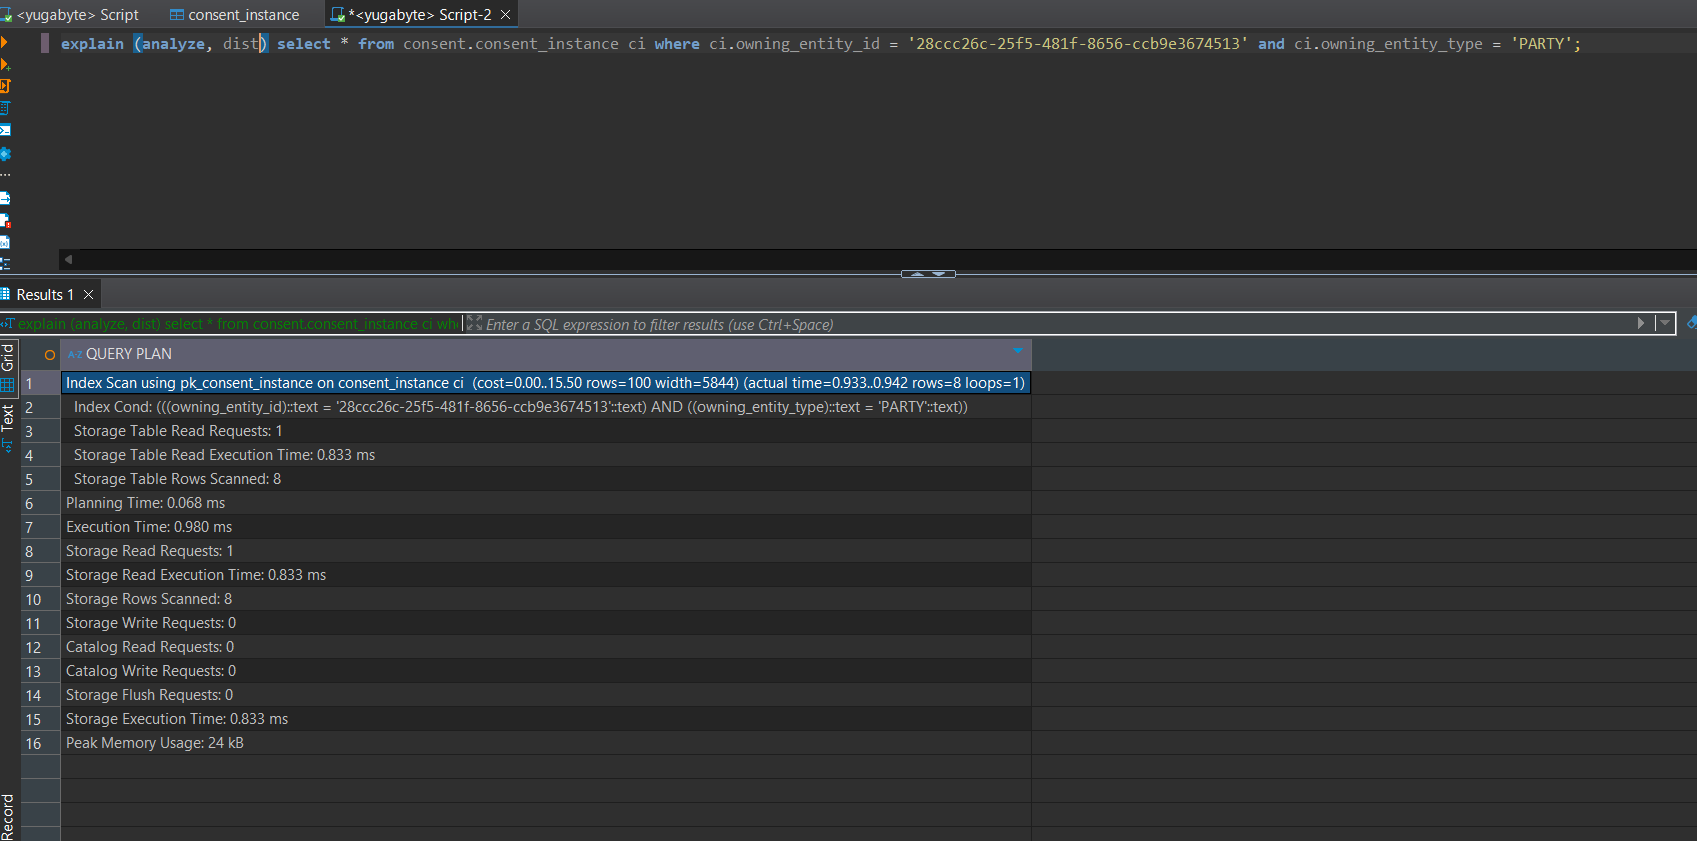

___
### Explian Plan for owning_entity_type and owning_entity_id and consent config identifier

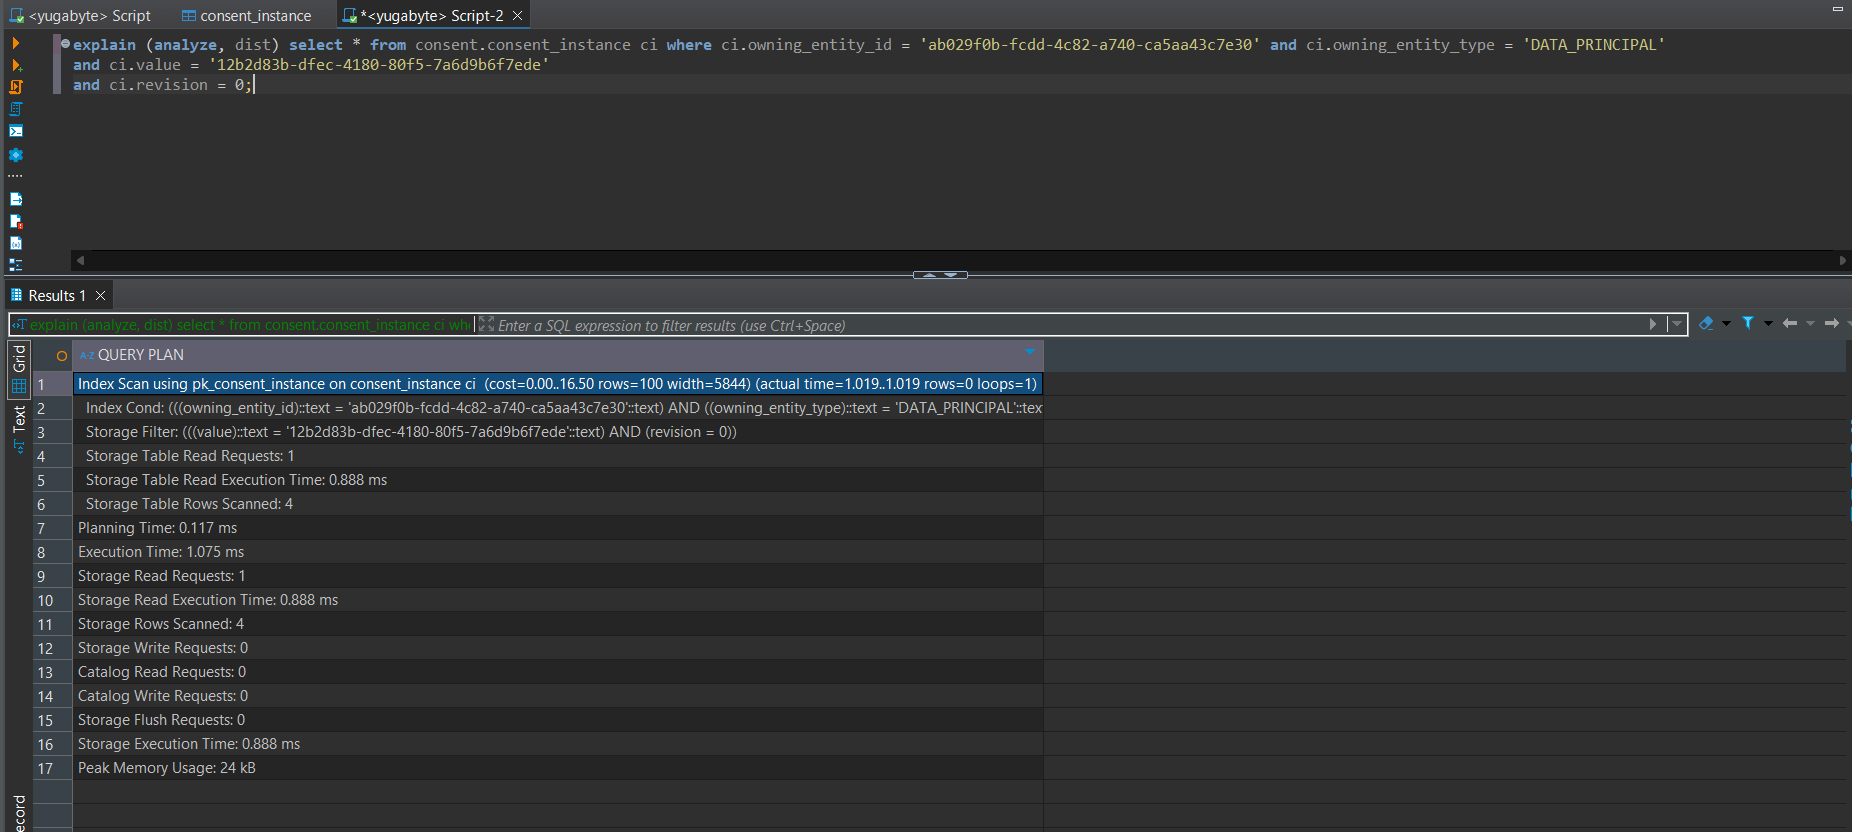

___
### Explian Plan for owning_entity_type and owning_entity_id and consent config identifier and purpose

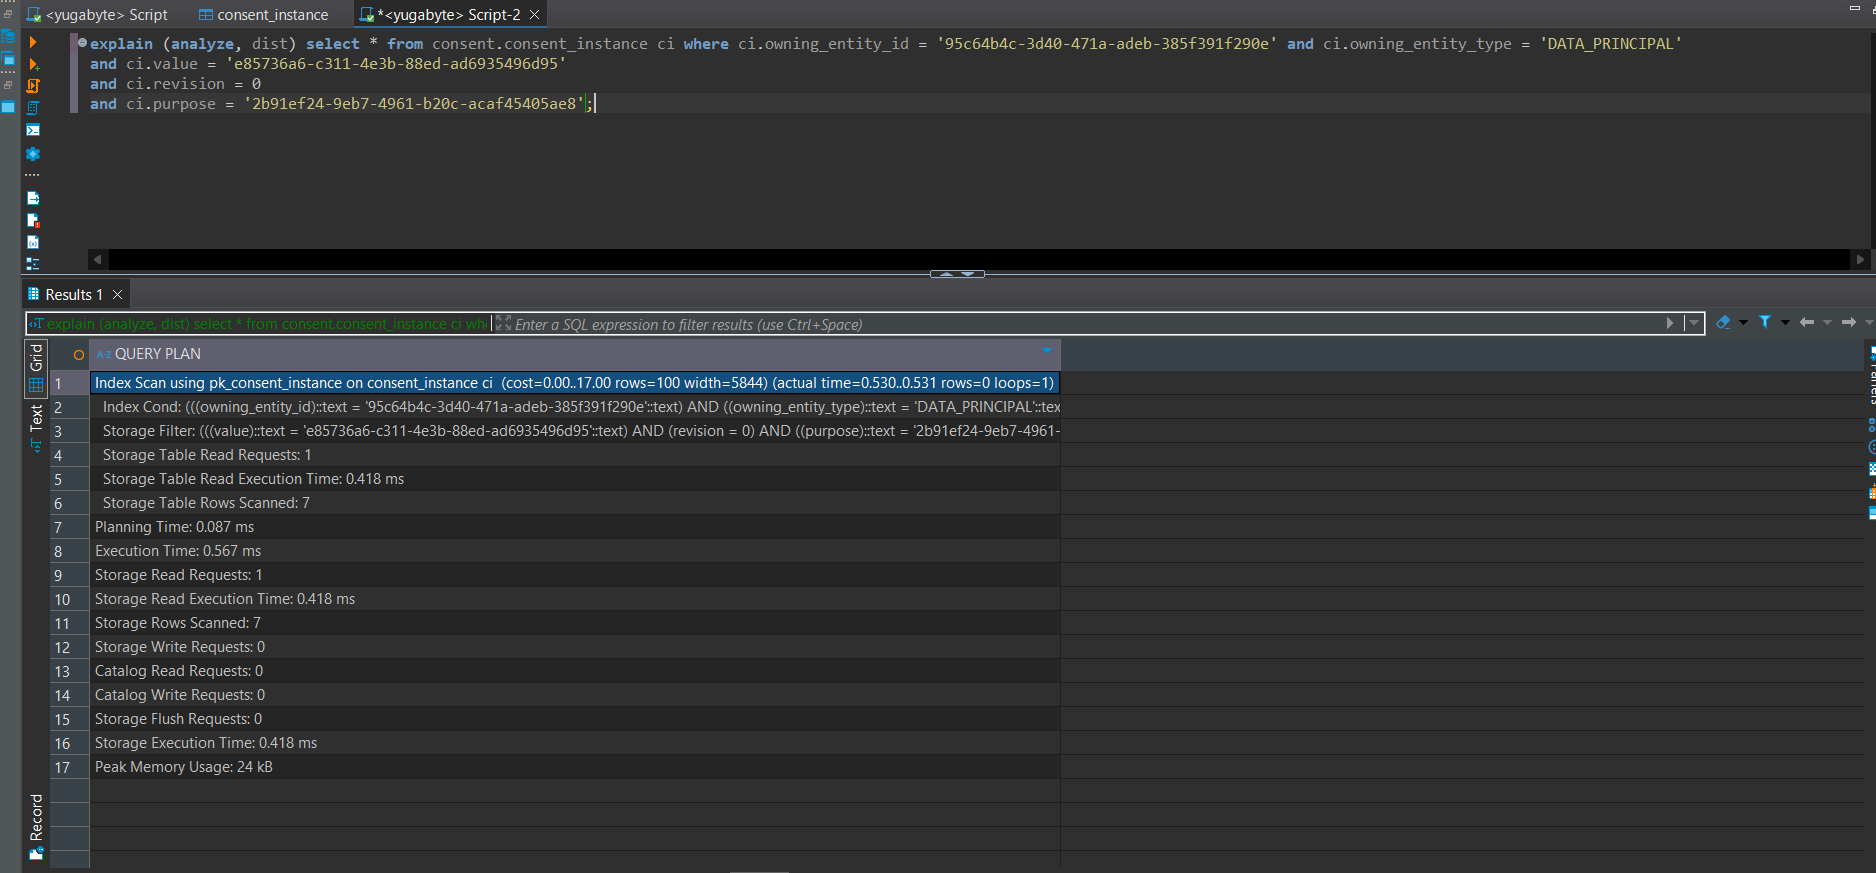

___
### Explian Plan for owning_entity_type and owning_entity_id and consent config identifier and purpose and context_details

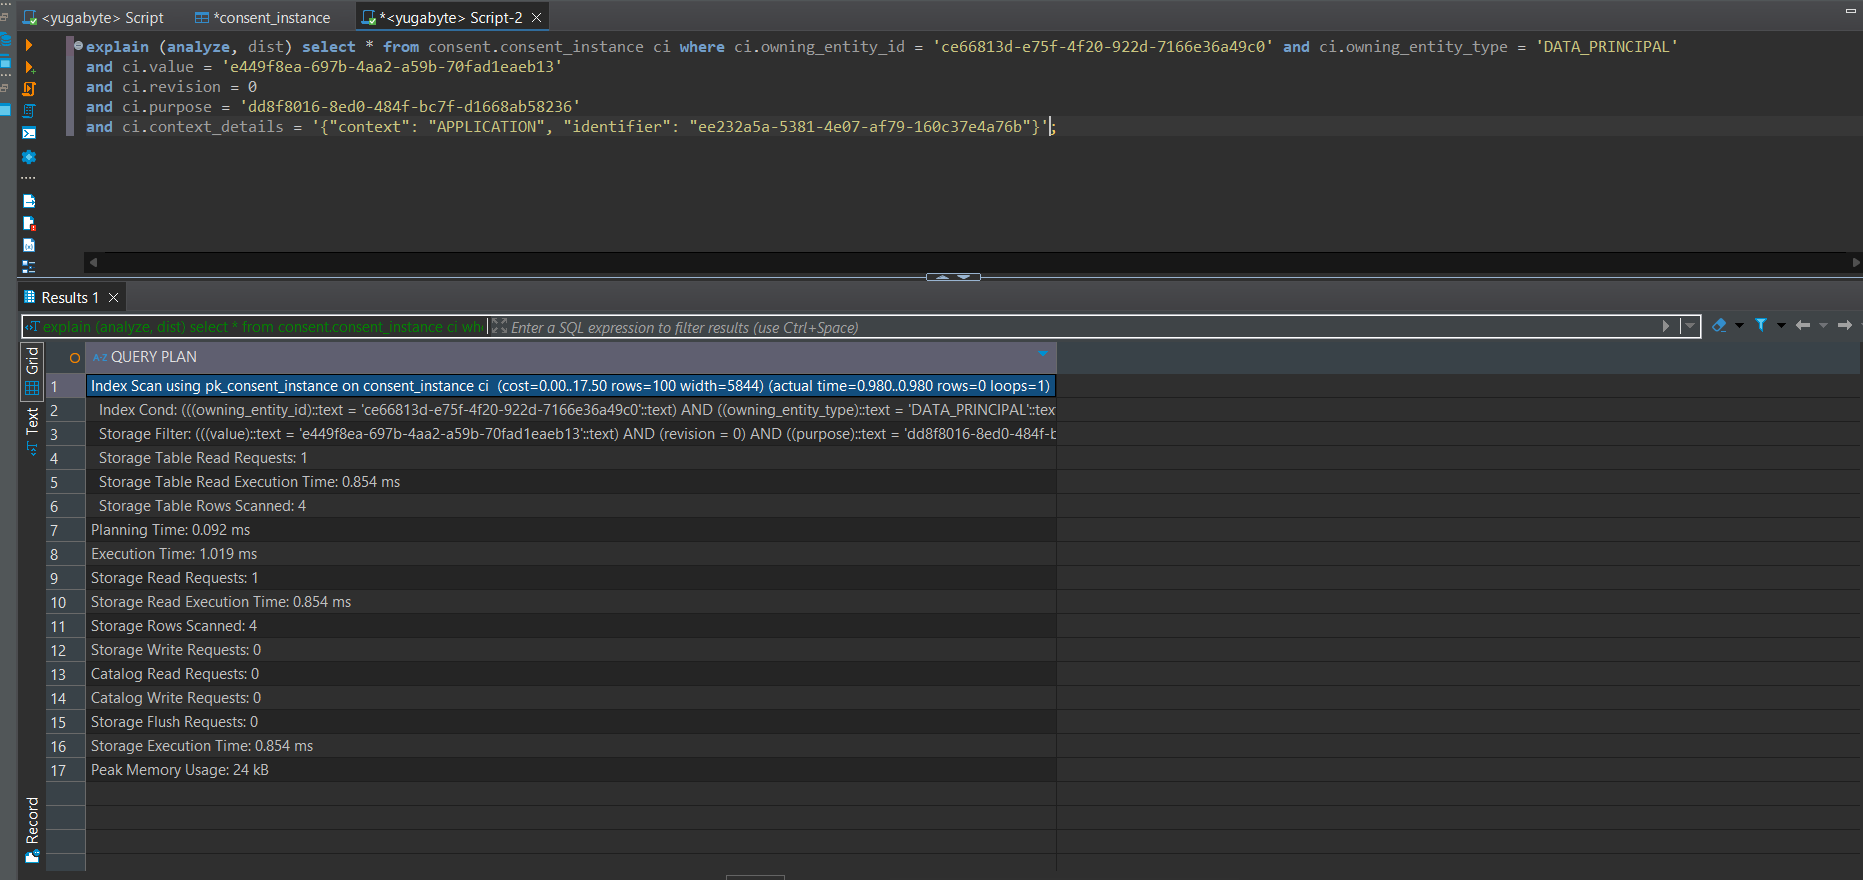

___
### Explian Plan for id

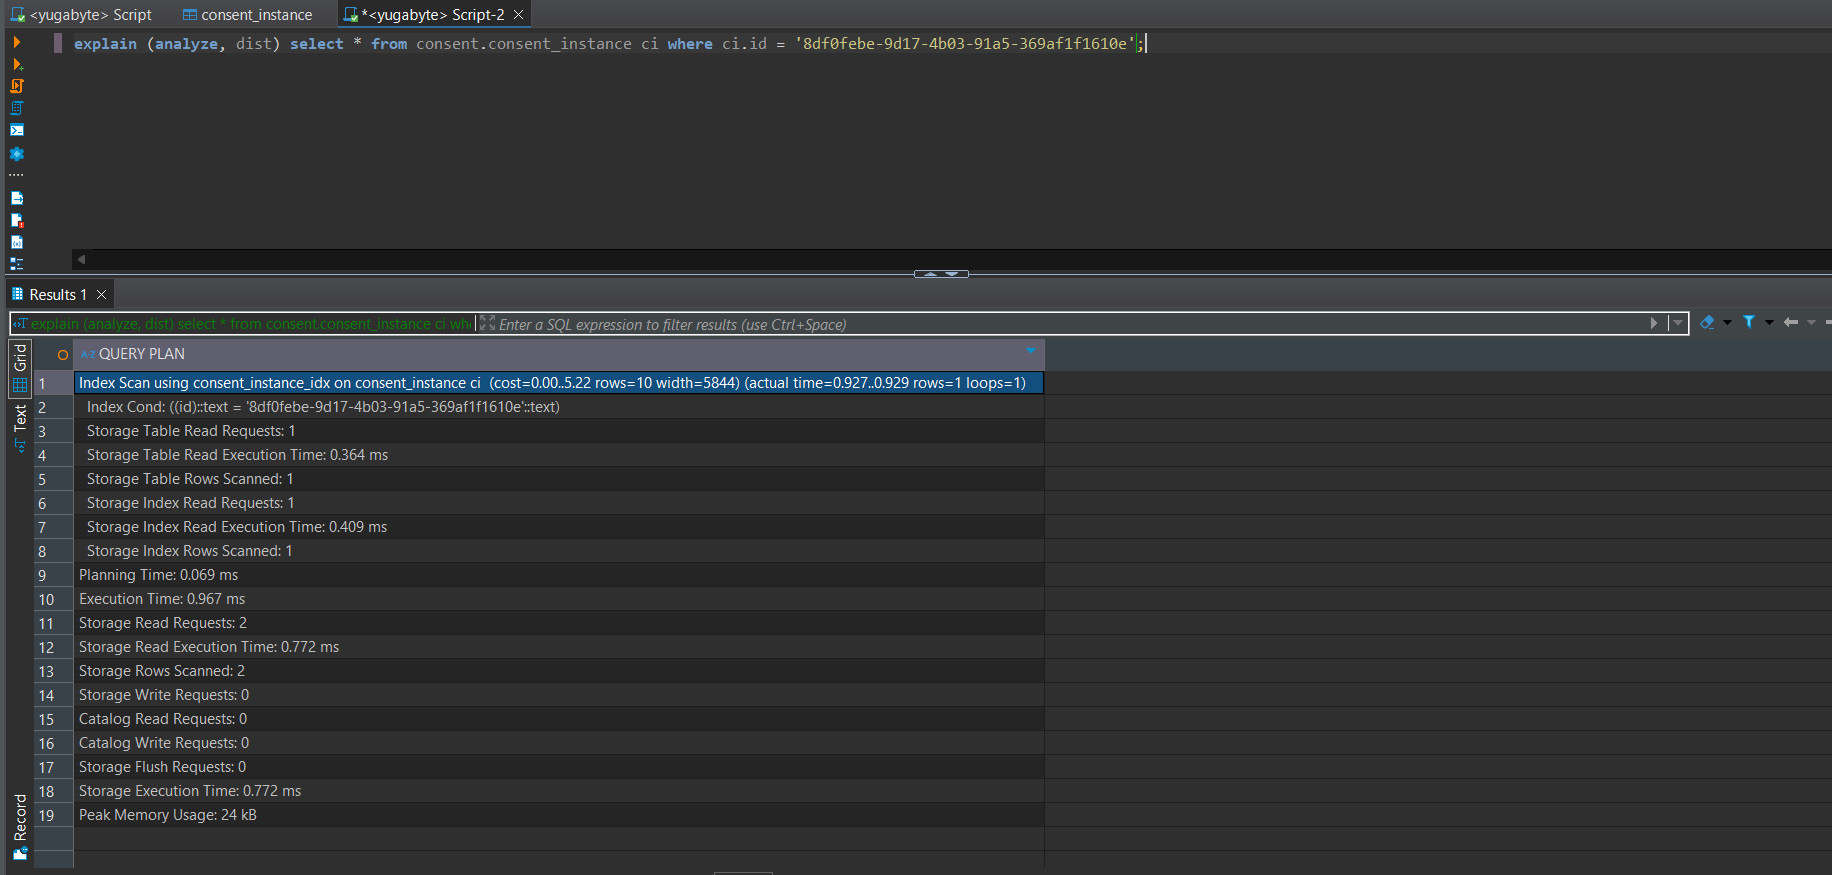

___
### Explian Plan for ids IN (12 ids)

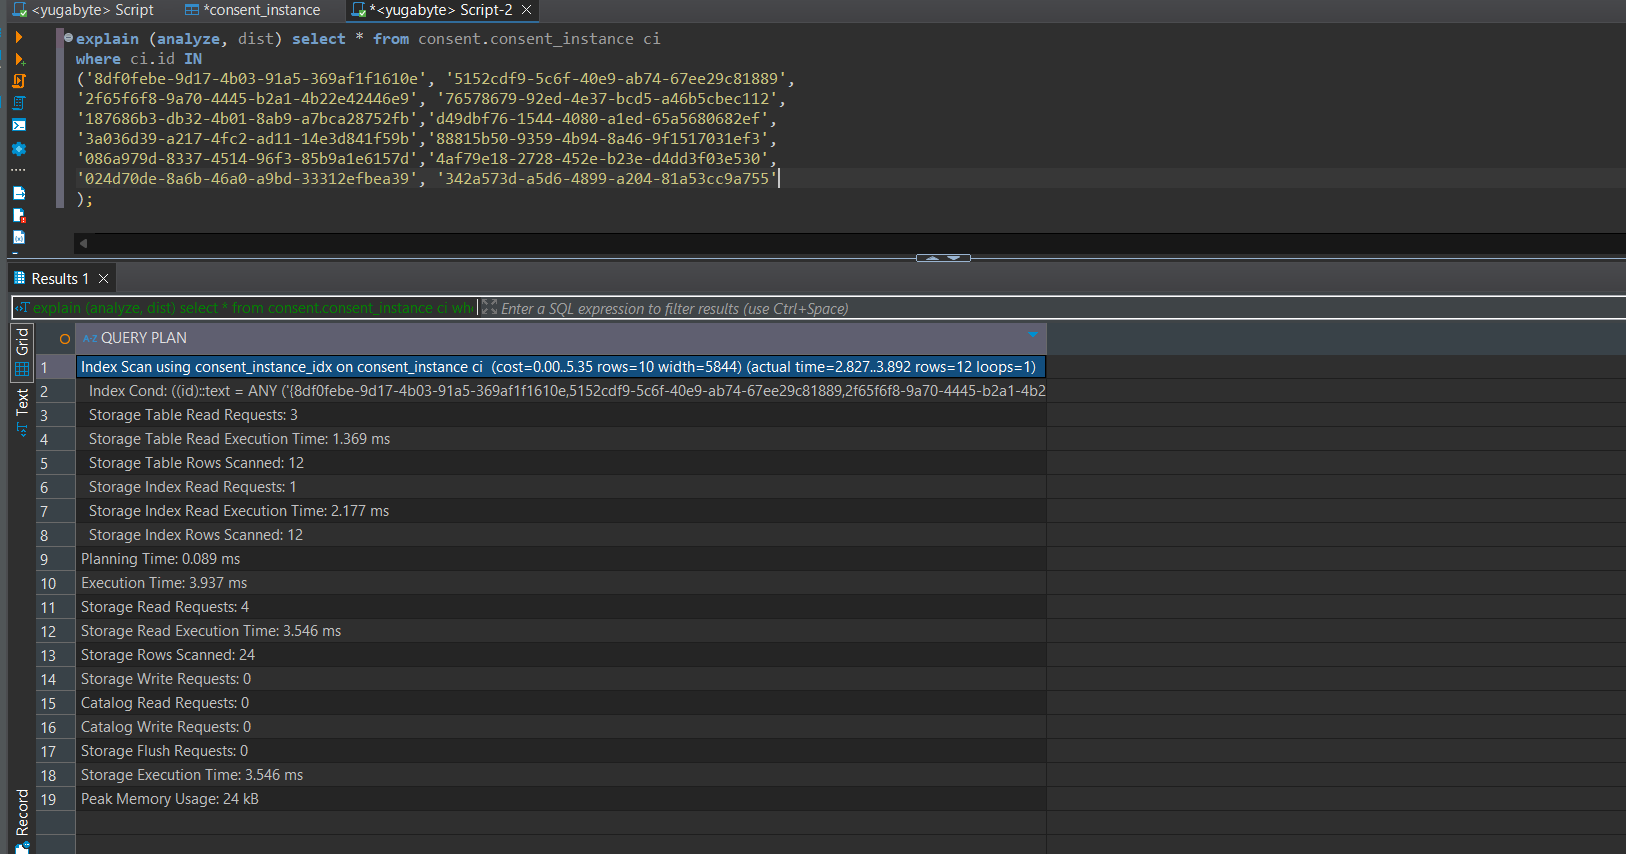

___
### Yugabyte DB Info (~ 1 Million Records)

#### Nodes info :
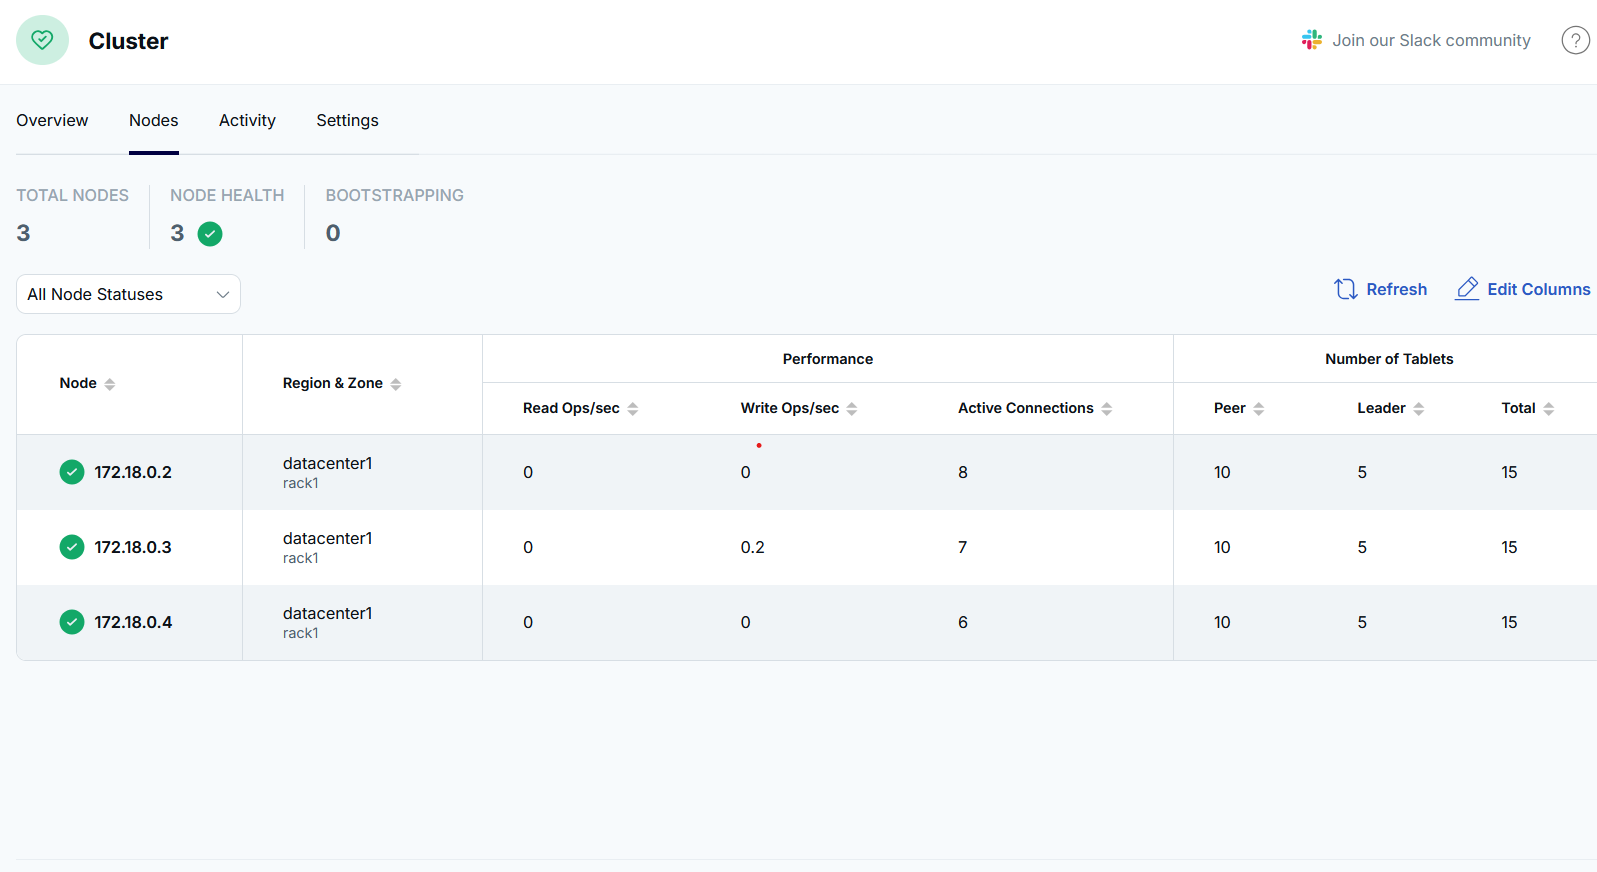

#### Tables info :
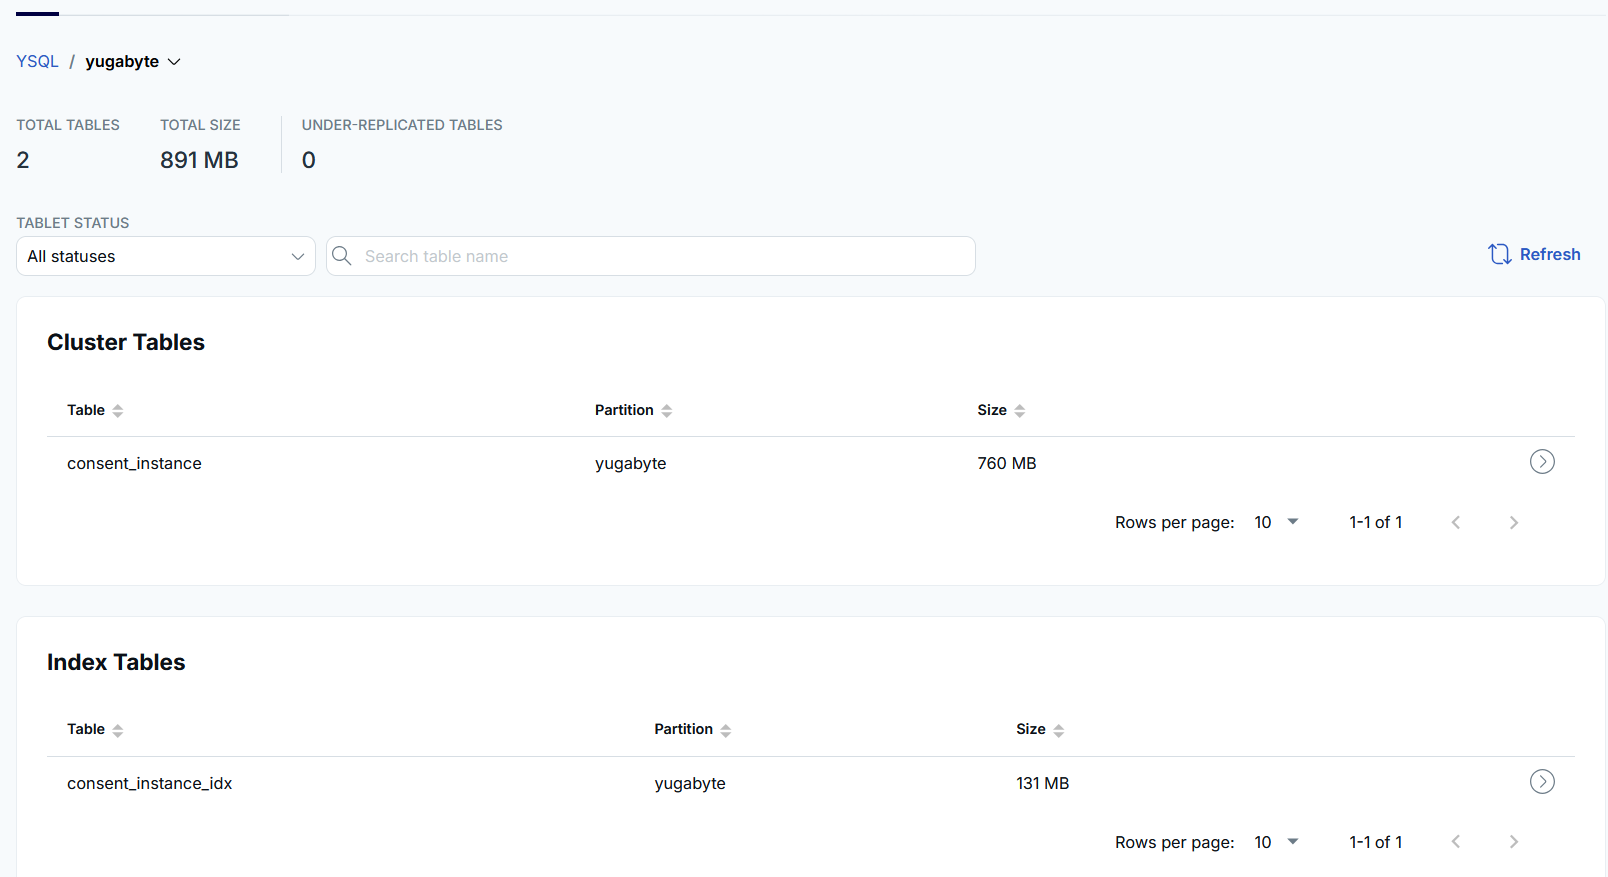

#### Tablets info :
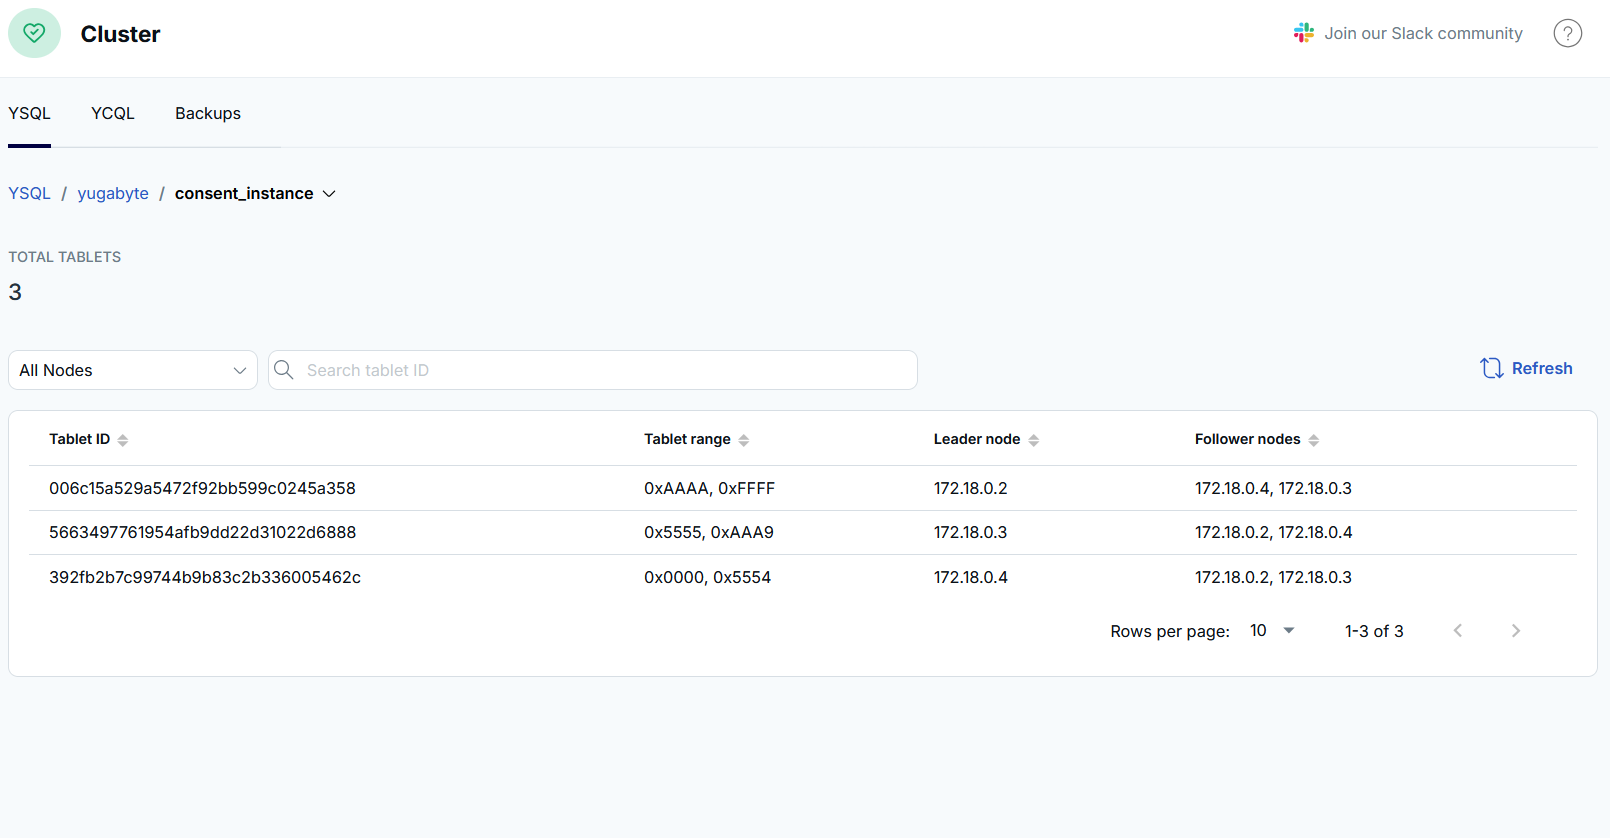
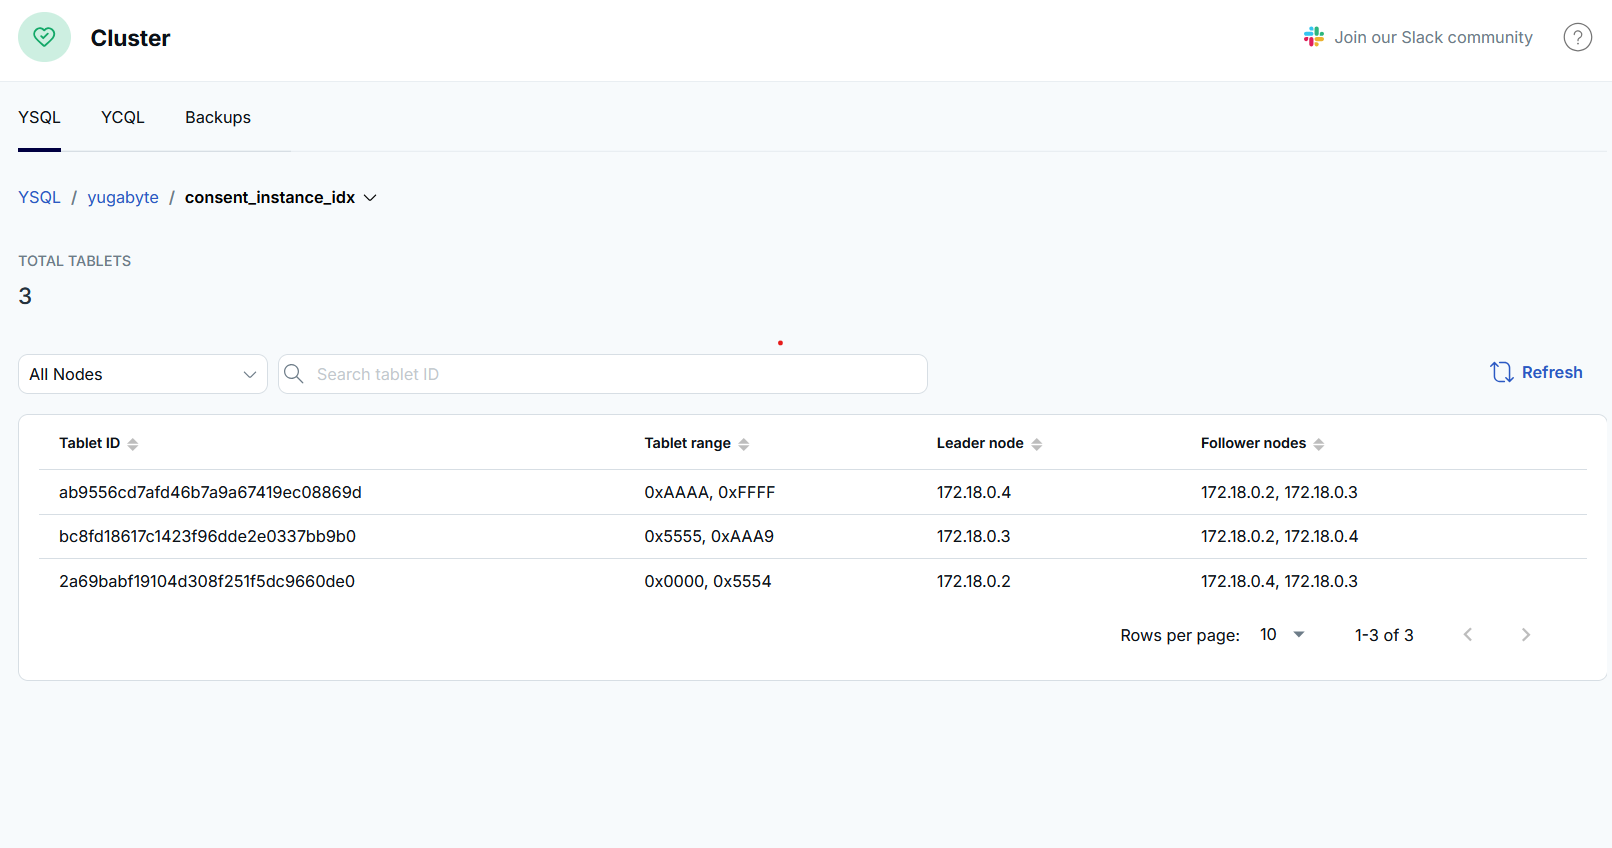